In [26]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../..')

In [27]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [28]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.utils import get_spark_session
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

In [29]:
import random
import numpy as np

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [30]:
from rs_datasets import MovieLens

In [31]:
movielens = MovieLens("1m")
interactions = movielens.ratings

In [32]:
interactions['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [33]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 6040
Number of unique items: 3706


In [34]:
pd.to_datetime(interactions['timestamp'], unit='s').describe()

count                          1000209
mean     2000-10-22 19:41:35.404665856
min                2000-04-25 23:05:32
25%                2000-08-03 11:37:17
50%                2000-10-31 18:46:46
75%                2000-11-26 06:42:19
max                2003-02-28 17:49:50
Name: timestamp, dtype: object

In [35]:
pd.to_datetime(interactions['timestamp'], unit='s')

0         2000-12-31 22:12:40
1         2000-12-31 22:35:09
2         2000-12-31 22:32:48
3         2000-12-31 22:04:35
4         2001-01-06 23:38:11
                  ...        
1000204   2000-04-26 02:35:41
1000205   2000-04-25 23:21:27
1000206   2000-04-25 23:19:06
1000207   2000-04-26 02:20:48
1000208   2000-04-26 02:19:29
Name: timestamp, Length: 1000209, dtype: datetime64[ns]

In [36]:
interactions.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


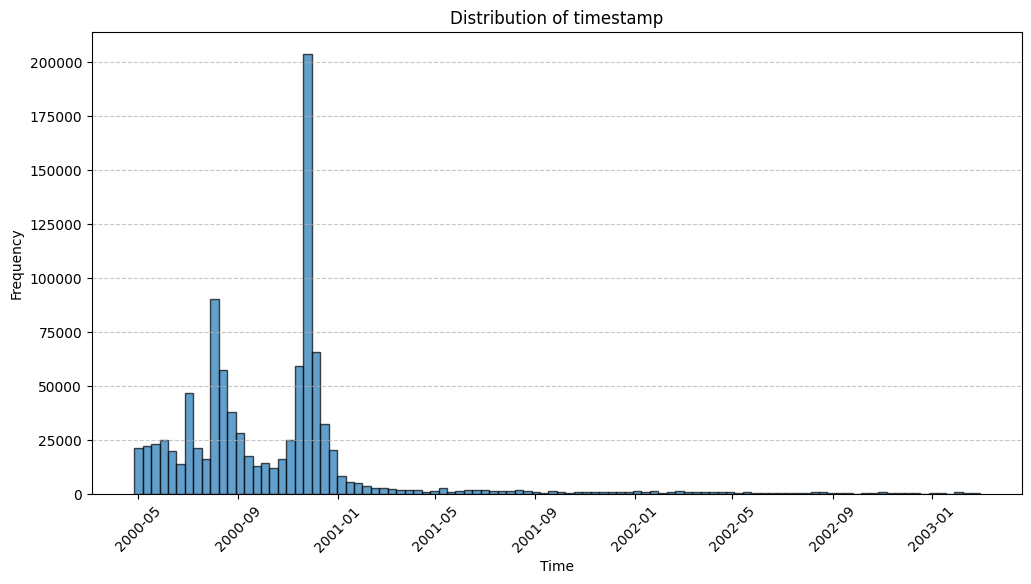

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 's', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [38]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [39]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min items per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min items per user: 1, Min users per item: 1
After filtering - Min items per user: 4, Min users per item: 5


In [40]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='s'))
print(pd.to_datetime(interactions.timestamp.max(), unit='s'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(574380, 4)
2000-04-25 23:05:32
2003-02-28 17:49:50
Interaction Density: 3.05%
Mean Sequence Length: 95.17


In [41]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 6035
Number of unique items: 3125


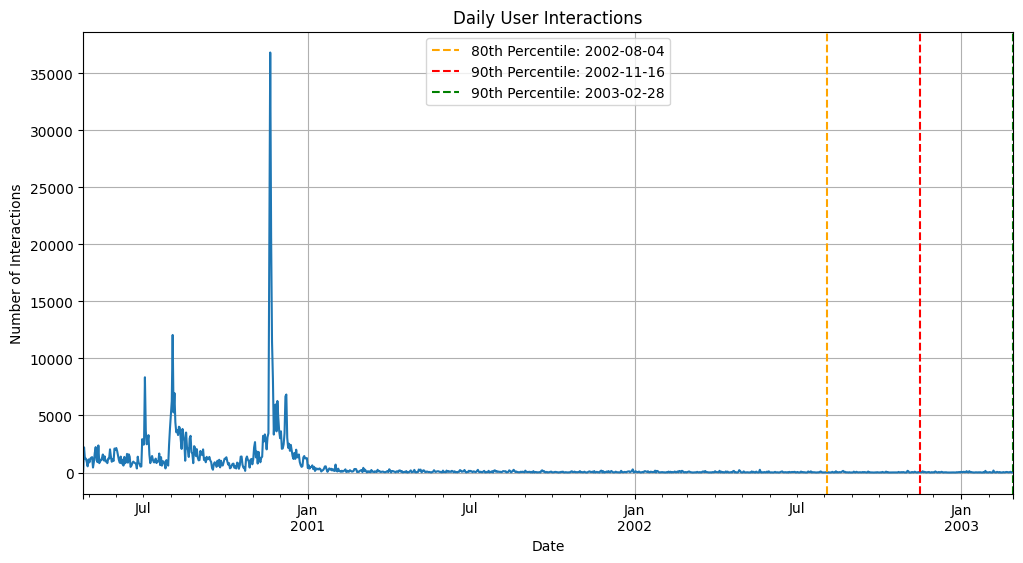

In [42]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='s')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'90th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    448.000000
mean      24.837054
std       49.389768
min        1.000000
25%        2.000000
50%        6.500000
75%       26.000000
max      656.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    999.000000
mean      43.796797
std       59.198925
min        1.000000
25%        7.000000
50%       23.000000
75%       57.000000
max      585.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    448.000000
mean      23.379464
std       37.653474
min        1.000000
25%        2.000000
50%        6.500000
75%       26.000000
max      200.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    999.000000
mean      41.581582
std       49.187966
min        1.000000
25%        7.000000
50%       23.000000
75%       57.000000
max      200.000000
Name: item_id, dtype: float64.


In [44]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [45]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [46]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 2858
Number of unique query_ids: 448


count     448.000000
mean      144.654018
std       141.518573
min         1.000000
25%        52.000000
50%       101.500000
75%       195.750000
max      1200.000000
Name: item_id_seq, dtype: float64

In [70]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 2059
Number of unique query_ids: 448
count    448.000000
mean      23.379464
std       37.653474
min        1.000000
25%        2.000000
50%        6.500000
75%       26.000000
max      200.000000
Name: item_id_seq, dtype: float64
(10474, 4)


In [48]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 3023
Number of unique query_ids: 999


count     999.00000
mean      137.37037
std       133.57312
min         1.00000
25%        46.00000
50%        99.00000
75%       186.00000
max      1215.00000
Name: item_id_seq, dtype: float64

In [63]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 2764
Number of unique query_ids: 999
count    999.000000
mean      41.581582
std       49.187966
min        1.000000
25%        7.000000
50%       23.000000
75%       57.000000
max      200.000000
Name: item_id, dtype: float64
(41540, 4)


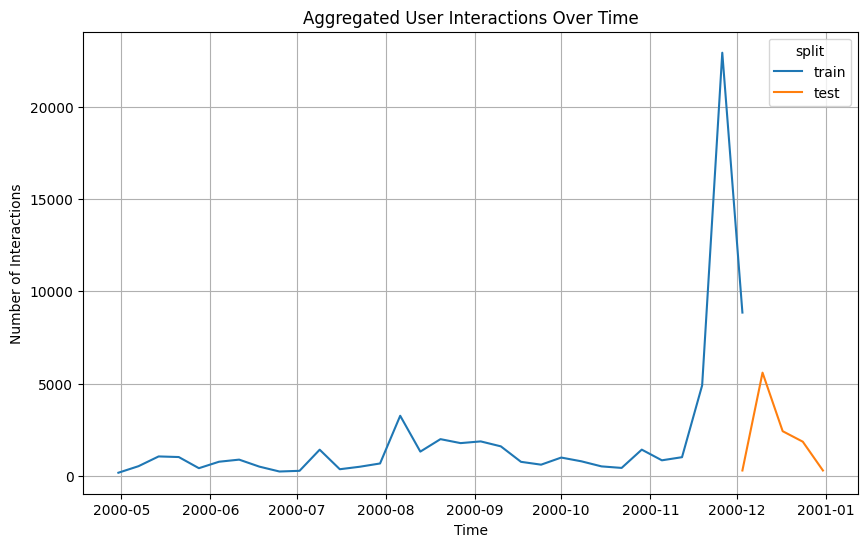

In [50]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='s')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

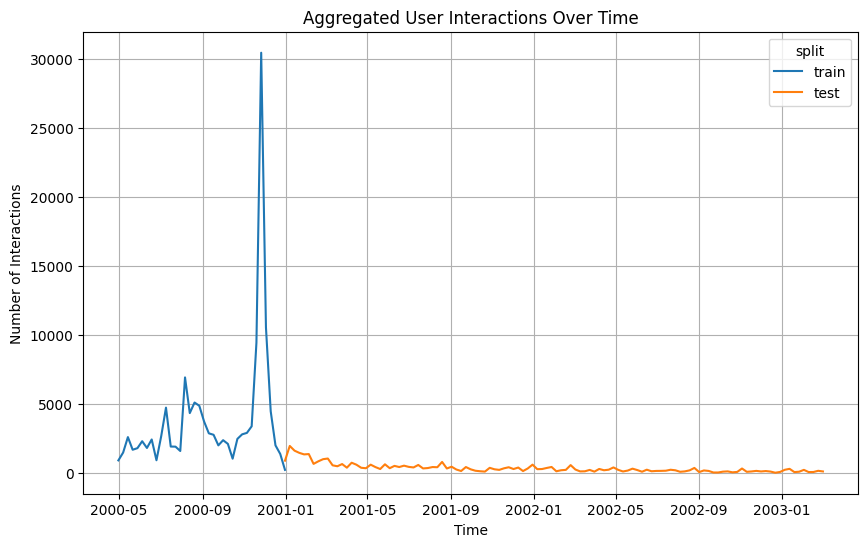

In [51]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

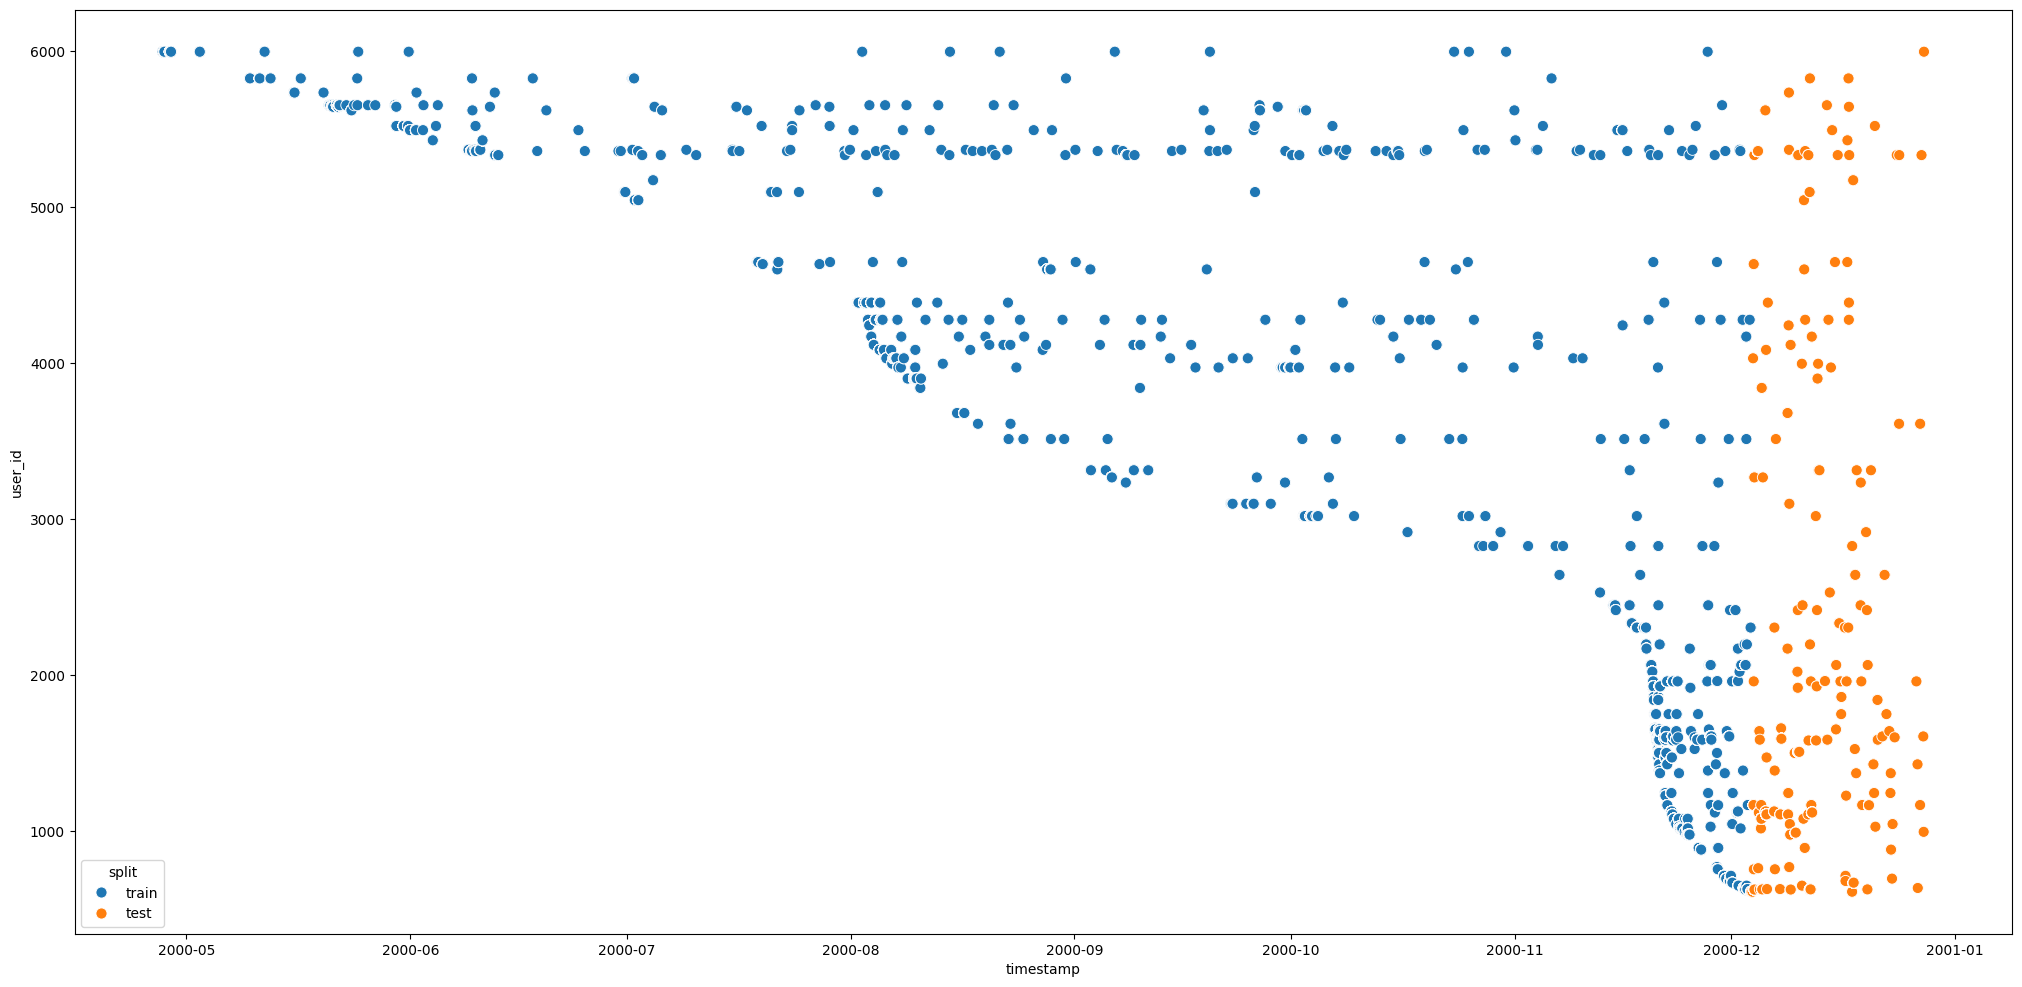

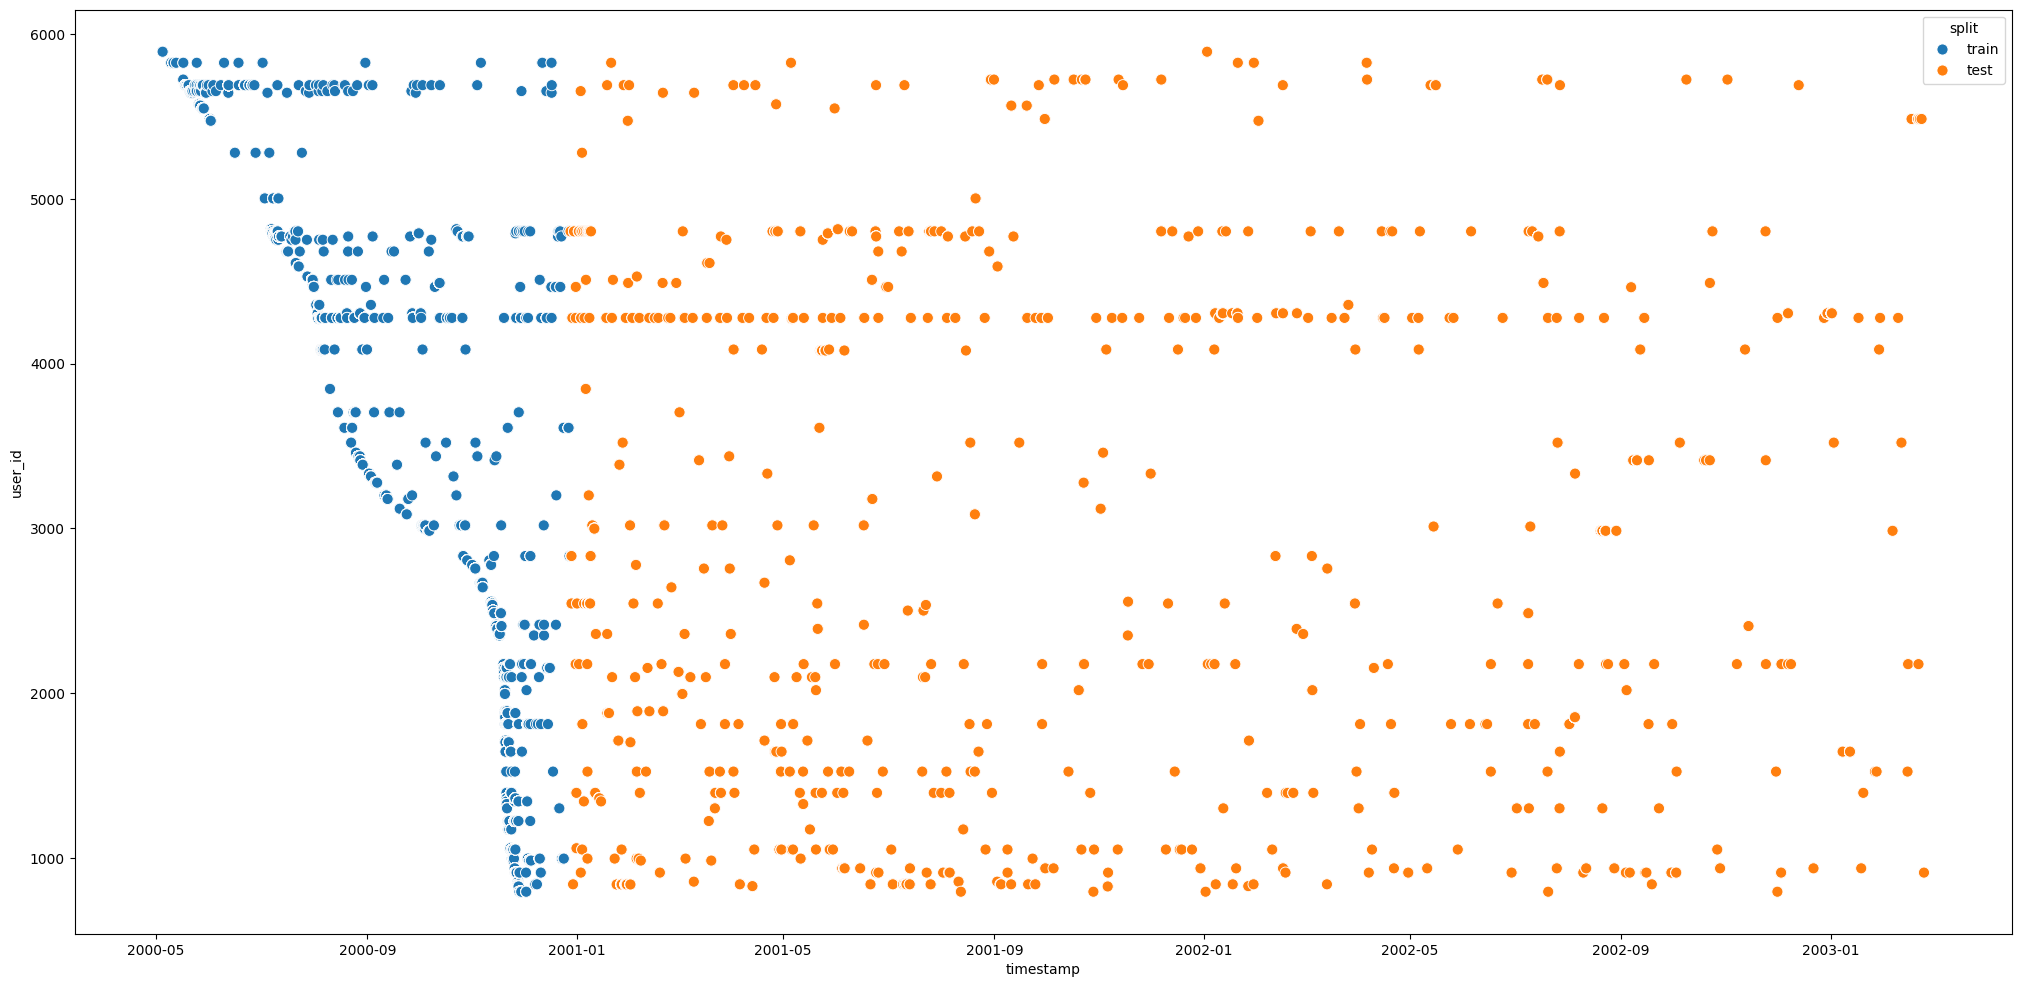

In [52]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='s')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [53]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
1000138,6040,858,4,956703932
999873,6040,593,5,956703954
1000153,6040,2384,4,956703954
1000192,6040,2019,5,956703977
1000007,6040,1961,4,956703977
...,...,...,...,...
91683,608,3555,4,975865456
140659,904,3476,4,975865478
140589,904,1407,4,975865478
91585,608,3409,5,975865484


In [54]:
len(set(splits['train'].item_id))

3120

In [55]:
len(set(val_gt.item_id))

2059

In [56]:
len(set(test_gt.item_id)) 

2764

In [57]:
len(set(test_gt.item_id) - set(val_gt.item_id))

785

In [58]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
999868,6040,573,4,956704056
999992,6040,326,4,956704519
999934,6040,290,4,956705162
999613,6037,1941,4,956709629
999457,6036,2758,4,956710067
...,...,...,...,...
91584,608,2606,4,975864927
91714,608,2026,4,975865073
140787,904,1983,4,975865274
91706,608,3743,5,975865313


In [59]:
len(set(val_gt.item_id) - set(test_gt.item_id))

80

In [60]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
998664,6036,1413,4,956710440
999121,6036,2972,4,956710800
998663,6036,1412,4,956710974
998938,6036,3132,5,956712862
999589,6037,3132,4,956719360
...,...,...,...,...
696654,4169,335,4,975804117
695777,4169,1450,4,975804348
304655,1812,3063,4,975820422
265290,1611,1976,4,975827943


In [61]:
test_gt

,user_id,item_id,rating,timestamp
140725,904,2348,4,977939424
140660,904,260,5,977939543
140721,904,858,4,977939543
140696,904,1193,4,977939573
140668,904,2866,5,977939573
...,...,...,...,...
825497,4958,2453,4,1046454260
825526,4958,3489,4,1046454320
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548


In [62]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
140725,904,2348,4,977939424
140660,904,260,5,977939543
140721,904,858,4,977939543
140696,904,1193,4,977939573
140668,904,2866,5,977939573
...,...,...,...,...
825497,4958,2453,4,1046454260
825526,4958,3489,4,1046454320
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
